In [6]:
import pandas as pd
df = pd.read_csv("log.txt", header = 0)

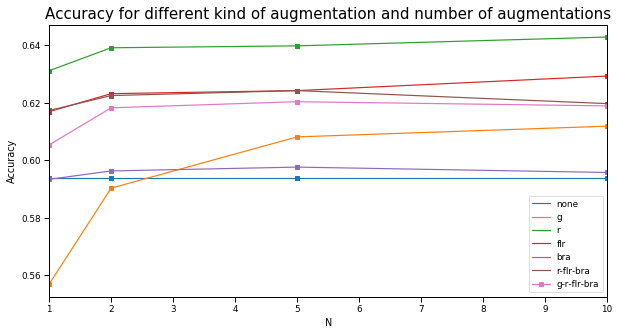

In [42]:
import seaborn as sns
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Accuracy for different kind of augmentation and number of augmentations", fontsize=15)
for aug in pd.unique(df["augs"]):
    df[(df["epsilon"] == 0.2)&(df["augs"] == aug)].plot(x = "n", y = "accuracy", ax = ax, label=aug, style = "-s")
ax.set_ylabel("Accuracy")
ax.set_xlabel("N")
plt.savefig("accuracyplot.png",bbox_inches='tight',dpi=100)

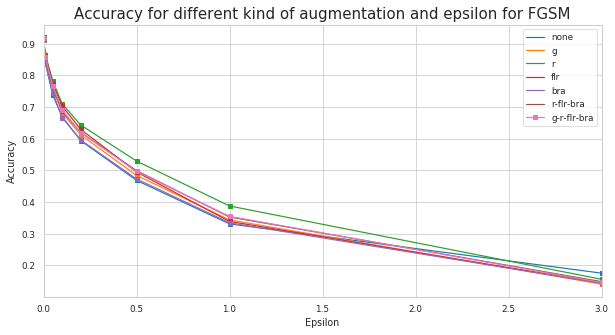

In [51]:
import seaborn as sns
sns.set_context("paper")
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title("Accuracy for different kind of augmentation and epsilon for FGSM", fontsize=15)
for aug in pd.unique(df["augs"]):
    df[(df["n"] == 10)&(df["augs"] == aug)].plot(x = "epsilon", y = "accuracy", ax = ax, label=aug, style = "-s")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epsilon")
plt.savefig("accuracyplot.png",bbox_inches='tight',dpi=100)

In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#root_path = '/content/gdrive/My Drive/Colab Notebooks/MyModel'
#import sys
#sys.path.append(root_path)
#https://github.com/huyvnphan/PyTorch-CIFAR10/blob/master/CIFAR10.ipynb

In [24]:
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.utils.data
import os
import torch.nn.functional as F
import time
import torch.distributions as td

#plots
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib import rcParams

#math
import numpy as np
from numpy.random import random
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from scipy.linalg import sqrtm

#modules
from cifar10_models import resnet
import data_loader
import visualize
import train_model
import FGSM
import augment
import utility

import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Size of training set: 50000
Size of validation set: 7500
Size of test set: 2500


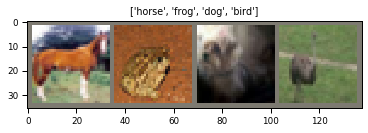

In [43]:
#LOAD DATA
batch_size=100
trainloader, validloader, testloader, attributes=data_loader.load_cifar10(batch_size, valid_ratio=.75)
N_test=attributes["N_test"]
N_train=attributes["N_train"]
N_valid = attributes["N_valid"]
classes=attributes["class_names"]
print("Size of training set: {}".format(N_train))
print("Size of validation set: {}".format(N_valid))
print("Size of test set: {}".format(N_test))
# VISUALIZE
inputs, class_data = next(iter(trainloader))
visualize.imshow(inputs[:4], title=[classes[i] for i in class_data[:4]], savefigure="example1")

Now doing the augmentation of the images, let us illustrate it with flipping the images.

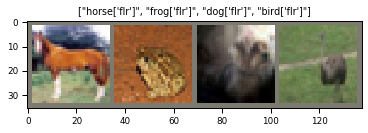

In [44]:
aug_batches, aug_seqs, aug_seqs_names = augment.compute_augmentations(inputs[:4], n = 1, depth = 1, augmentations="flr", flip_p=1)
for i, _ in enumerate(aug_seqs_names):
    visualize.imshow(aug_batches[i], title=[classes[j]+str(aug_seqs_names[i]) for j in class_data[:4]], savefigure="example2")

Loading the pretrained ResNet model:

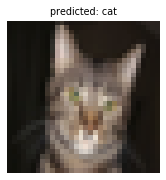

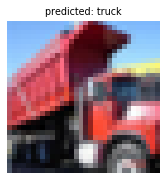

In [45]:
# load the pretrained resnet 18/34 or 50
path="cifar10_models/state_dicts/resnet18.pt"
model = resnet.resnet18(pretrained=True).to(device)
# train if necessary
# model_ft = train_model.train(model, trainloader, testloader,num_epochs=2)

model.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
model.eval()
visualize.visualize_model(model, testloader, classes, num_images=2)

## TODO: SHOW BASE ACCURACY OF MODEL HERE

## The FGSM attack

Let us look at when it is possible for the human eye to detect an FGSM attack.

In [5]:
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

In [6]:
epsilon_images = []
original_images = []
l2_norms_images = []
for i in eps:
    adv_examples, original_input=FGSM.get_examples_fgsm(model, validloader, epsilon=i, limit=10)
    epsilon_images.append(adv_examples[0])
    original_images.append(original_input[0])
    diff = original_input-adv_examples
    l2_norms = torch.norm(diff.view(diff.shape[0], -1), p=2, dim=1)
    avg_l2norm = torch.mean(l2_norms, dim=0)
    l2_norms_images.append(round(l2_norms[0].item(),3))

Around $\epsilon=0.2$ it is possible to detect noise from the FGSM attack in the image

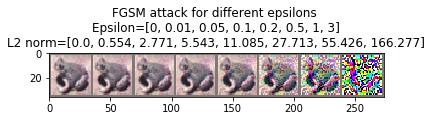

In [7]:
visualize.imshow(epsilon_images, title="FGSM attack for different epsilons \nEpsilon="+str(eps)+"\nL2 norm="+str(l2_norms_images), savefigure="fgsm_eps")

Looking at the model accuracy below it is clear that an attack makes the model accuracy a lot worse. Let us investigate how confident the model is with its predictions, e.g. does the model show large uncertainty when the adversarial attack occur?

In [9]:
figures=[]
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]
for count,i in enumerate(eps):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=i,
                                                                             augmentations = "none", n = 1)
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram\nEpsilon: {}".format(i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=count)
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)
    

Epsilon: 0	Test Accuracy = 7032 / 7500 = 0.9376
Expected Calibration Error: 0.04077045992016792
Epsilon: 0.01	Test Accuracy = 6279 / 7500 = 0.8372
Expected Calibration Error: 0.1256331205368042
Epsilon: 0.05	Test Accuracy = 4380 / 7500 = 0.584
Expected Calibration Error: 0.3641014099121094
Epsilon: 0.1	Test Accuracy = 3532 / 7500 = 0.4709333333333333
Expected Calibration Error: 0.4679544270038605
Epsilon: 0.2	Test Accuracy = 2744 / 7500 = 0.3658666666666667
Expected Calibration Error: 0.5477942228317261
Epsilon: 0.5	Test Accuracy = 1244 / 7500 = 0.16586666666666666
Expected Calibration Error: 0.6766688823699951
Epsilon: 1	Test Accuracy = 763 / 7500 = 0.10173333333333333
Expected Calibration Error: 0.6324409246444702
Epsilon: 3	Test Accuracy = 817 / 7500 = 0.10893333333333333
Expected Calibration Error: 0.5635567903518677


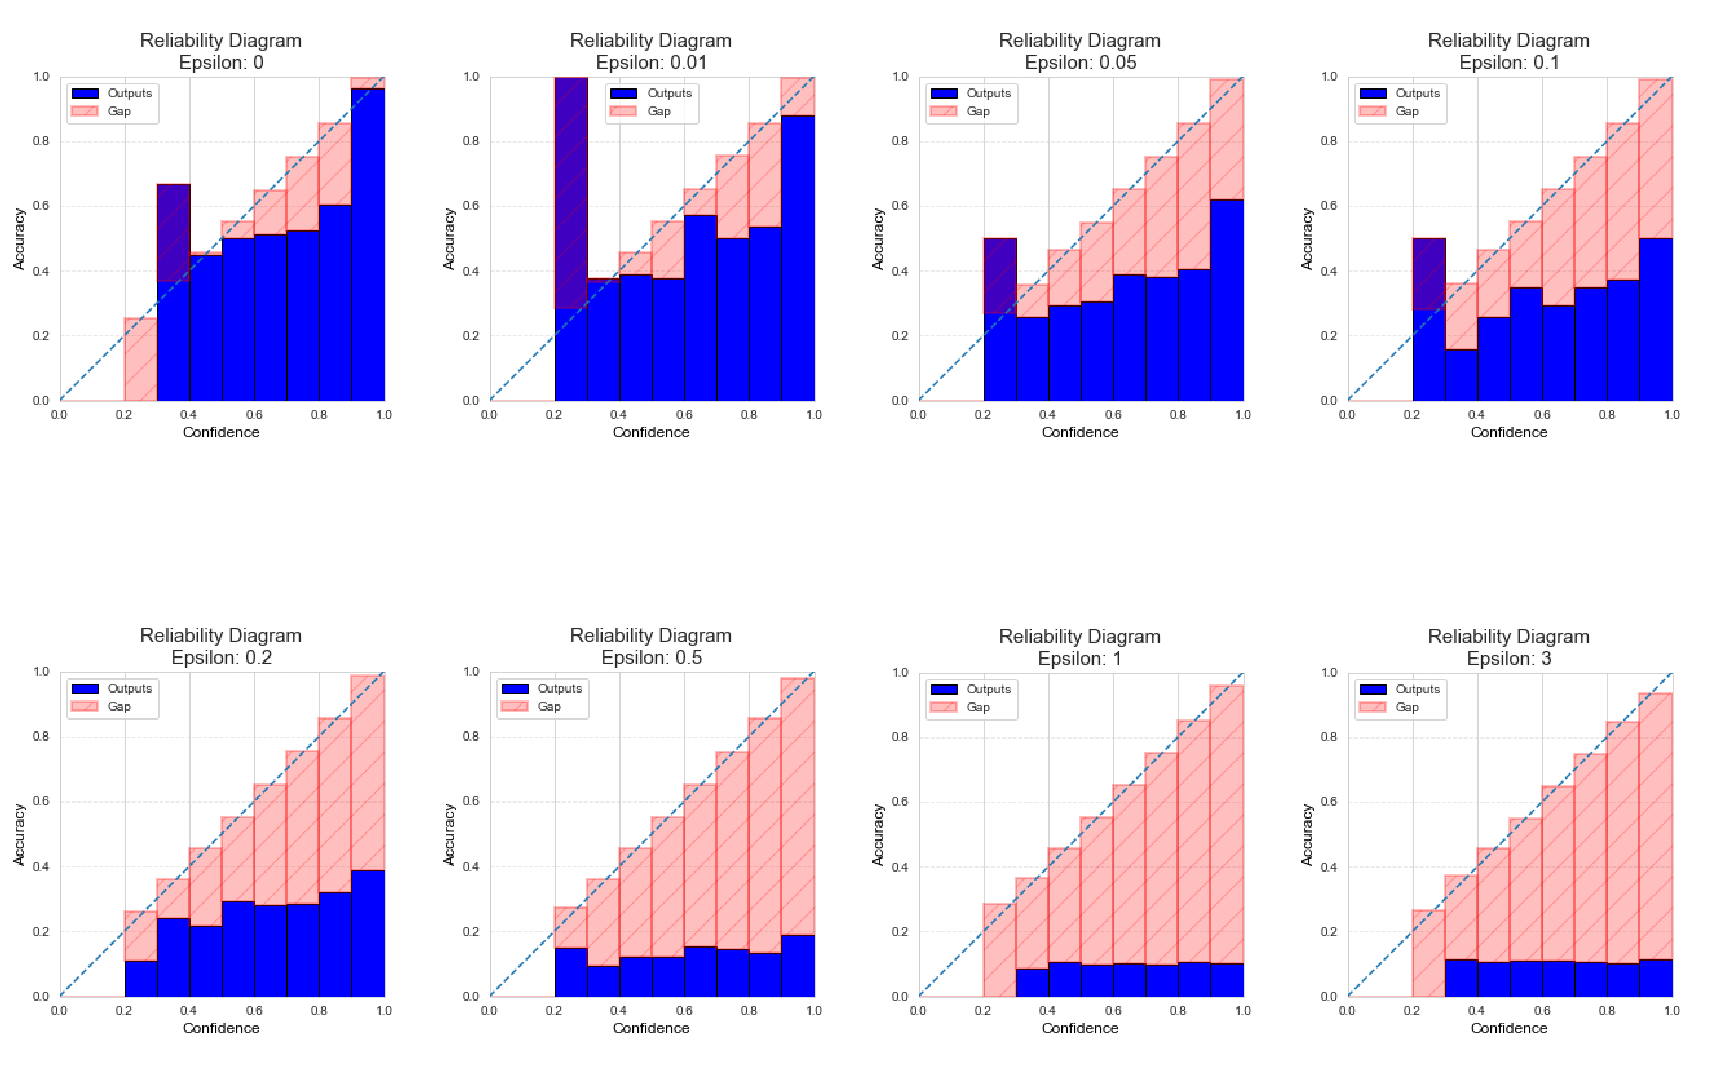

In [10]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()


We see that the accuracy gets worse and worse, but the confidence remains the same for an increasing $\epsilon$! The model needs to be calibrated.

## Introducing augmentations

# TODO SAMUEL INSERTS ACCURACY OF AUGMENTATIONS

20%
40%
60%
80%
100%
Epsilon: 0.2	Test Accuracy = 3298 / 7500 = 0.4397333333333333


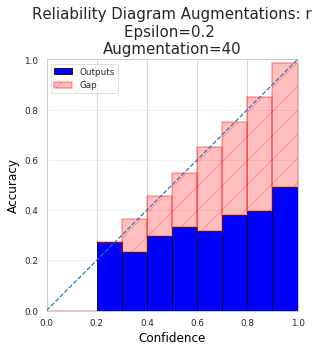

In [47]:
augmentations_list = ["none","g", "r", "flr", "bra", "r,flr,bra", "g,r,flr,bra"]
n_augs = [1,2,5,10]
eps = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]
figures=[]
results = []
augmentations_list=["r"]
n_augs = [40]
eps =[0.2]

for aug in augmentations_list:
    for n in n_augs:
        for epsilon in eps:
            final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 1, 
                                                                             epsilon=epsilon,
                                                                             augmentations = aug,
                                                                             n = n)
            #some statistics if necessary
            pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
            #get ece and bins
            ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
            #plot it
            if aug == "none":
                title = "Reliability Diagram No Augmentations\nEpsilon={}".format(epsilon)
            else:
                title = "Reliability Diagram Augmentations: {}\nEpsilon={} \nAugmentation={}".format(aug, epsilon,n)
            fig = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title)
            results.append({"augments":aug,"n":n,"epsilon":epsilon,"accuracy":final_acc,"ece":ece,"figure":fig})
            plt.figure(fig.number)
            plt.savefig("figures_20200422/reliability_diagram-n{}-aug{}-epsilon{}.png".format(n,aug.replace(",","-"),epsilon),bbox_inches='tight',dpi=100)
            break
            
        break
    break
    

In [48]:
print(fig)
plt.figure(fig.number)
plt.savefig("figures_20200422/reliability_diagram-n{}-aug{}-epsilon{}.png".format(n,aug.replace(",","-"),epsilon),bbox_inches='tight',dpi=100)

Figure(324x360)


<Figure size 432x288 with 0 Axes>

In [ ]:
import pandas as pd
import pickle

#df = pd.DataFrame(results)
#df.to_pickle("results_20200409.pandaspickle")
#df.head(140)
df.to_csv("results_20200409.csv")

## Looking at invariance of augmentations

To do this the FID score is used to compare how much the different augmentations affect the model.

In [11]:
#used to illustrate examples.
n_batches = 2
inputs_arr = []
iter_dataloader = iter(trainloader)
for _ in range(n_batches):
    cur_inputs, c =  next(iter_dataloader)
    inputs_arr.append(cur_inputs)
    
inputs = torch.cat(inputs_arr, dim = 0)
inputs.shape

# get model features
model_features, p = utility.get_features(model)

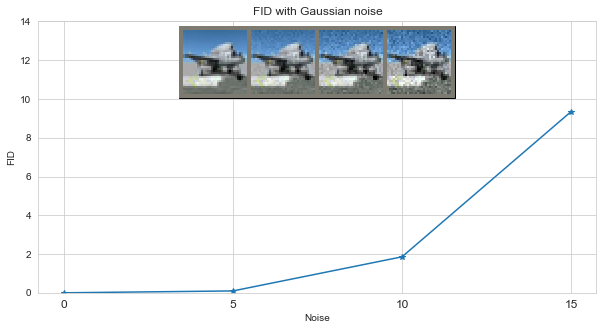

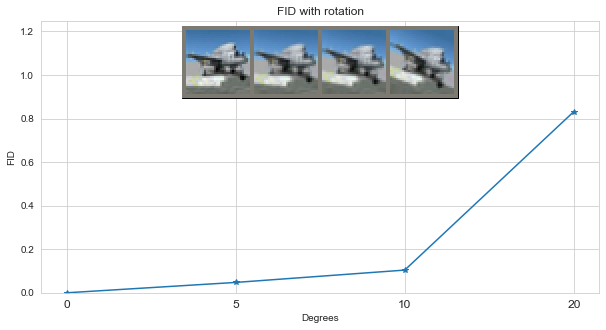

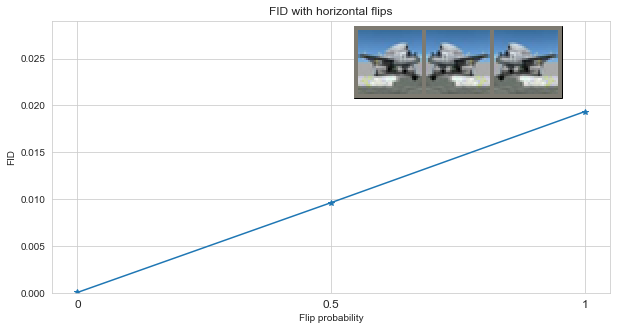

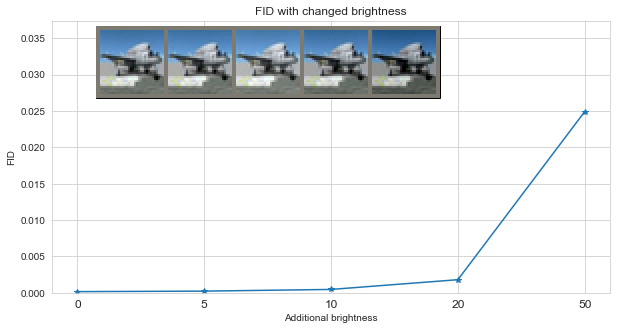

In [21]:
expansion=False
if expansion == True:
    bottleneck=True
else:
    bottleneck=False
    
params = [0,5,10,15]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="g", noise_level=params, bottleneck=bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with Gaussian noise",plot_n="gaus_aug_fid.png")

params = [0,5,10,20]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="r", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with rotation", xlabel="Degrees",plot_n="rot_aug_fid.png")

params = [0,0.5,1]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="flr", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title = "FID with horizontal flips", xlabel="Flip probability",plot_n="flr_aug_fid.png")

params = [0,5,10,20,50]
FID, plot_batch = utility.get_FID(inputs, model_features, device, augmentation="bra", noise_level=params, bottleneck = bottleneck)
utility.plot_fid(FID, plot_batch, x_labels=params, title="FID with changed brightness", xlabel="Additional brightness", plot_n="bright_aug_fid.png")

It is observed that the FID increases very little using augmentations such as brightness, rotation and flipping the image, indicating invariance towards these augmentations. The gaussian noise affects the model a lot. It might not be a good idea to introduce gaussian noise as a defense against adversarial attacks.

## Calibration when using augmentations

Let us look how calibration is affected when using augmentations

In [24]:
figures=[]
aug = ["r", "g","flr", "bra", "flr, bra", "flr,bra,r", "flr,r", "flr, g"]
n=1

for count,i in enumerate(aug):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = i, n = n);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(i, 0, n)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"aug")
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)
    

Epsilon: 0	Test Accuracy = 6847 / 7500 = 0.9129333333333334
Expected Calibration Error: 0.05736374855041504
Epsilon: 0	Test Accuracy = 4821 / 7500 = 0.6428
Expected Calibration Error: 0.2915172576904297
Epsilon: 0	Test Accuracy = 7020 / 7500 = 0.936
Expected Calibration Error: 0.0418783500790596
Epsilon: 0	Test Accuracy = 7007 / 7500 = 0.9342666666666667
Expected Calibration Error: 0.04246025159955025
Epsilon: 0	Test Accuracy = 7016 / 7500 = 0.9354666666666667
Expected Calibration Error: 0.04123581573367119
Epsilon: 0	Test Accuracy = 6975 / 7500 = 0.93
Expected Calibration Error: 0.04481741786003113
Epsilon: 0	Test Accuracy = 6942 / 7500 = 0.9256
Expected Calibration Error: 0.04944983124732971


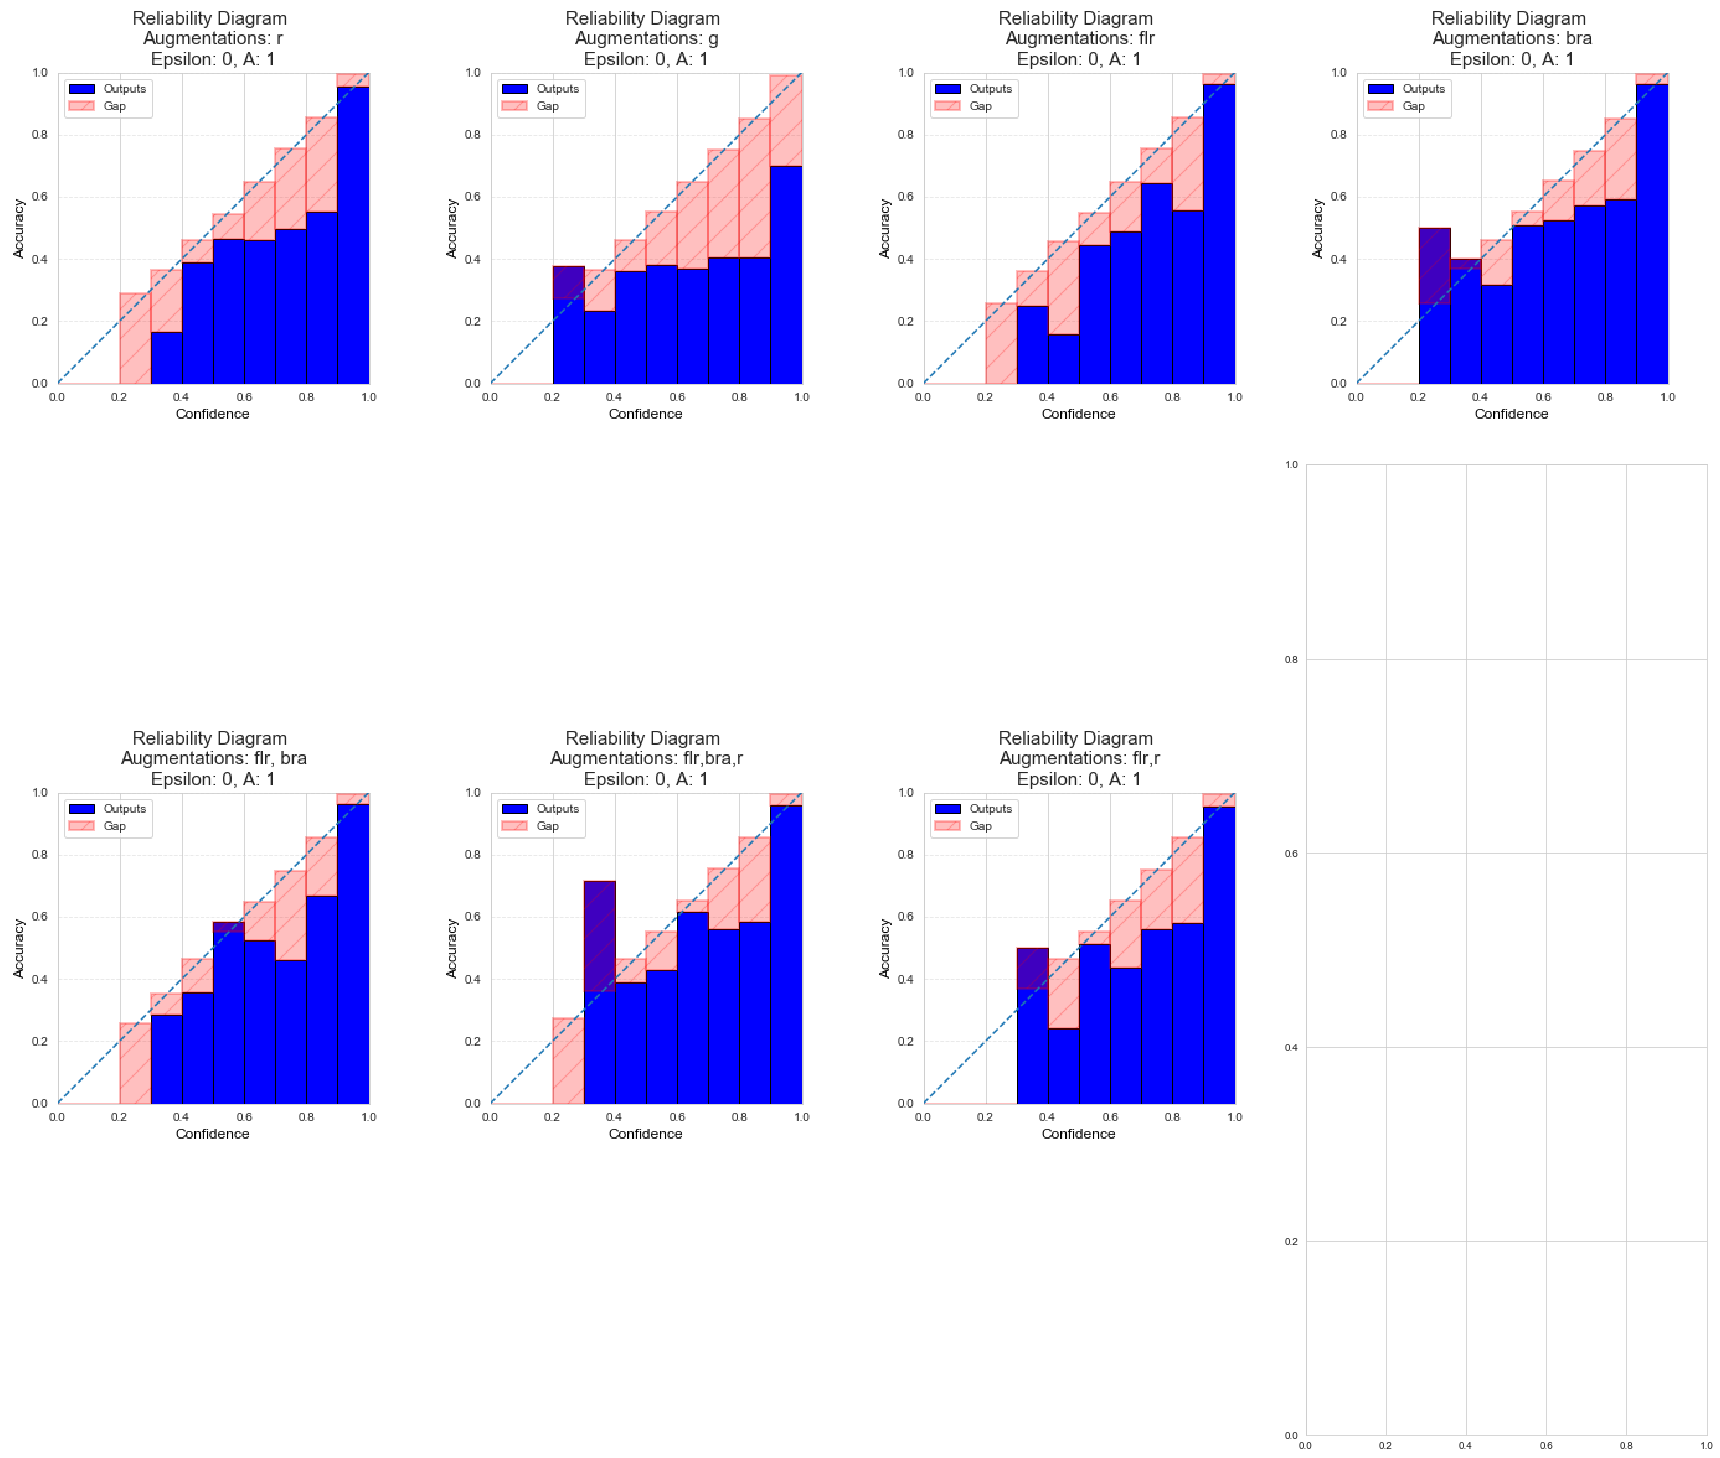

In [25]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"aug"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()


Changing n and eps:

Epsilon: 0	Test Accuracy = 7015 / 7500 = 0.9353333333333333
Expected Calibration Error: 0.041842423379421234
Epsilon: 0	Test Accuracy = 7045 / 7500 = 0.9393333333333334
Expected Calibration Error: 0.031133703887462616
Epsilon: 0	Test Accuracy = 7030 / 7500 = 0.9373333333333334
Expected Calibration Error: 0.03286382928490639
Epsilon: 0	Test Accuracy = 7028 / 7500 = 0.9370666666666667
Expected Calibration Error: 0.03191756829619408
Epsilon: 0	Test Accuracy = 7036 / 7500 = 0.9381333333333334
Expected Calibration Error: 0.029786711558699608
Epsilon: 0	Test Accuracy = 7038 / 7500 = 0.9384
Expected Calibration Error: 0.029522612690925598
Epsilon: 0	Test Accuracy = 7040 / 7500 = 0.9386666666666666
Expected Calibration Error: 0.028161095455288887
Epsilon: 0	Test Accuracy = 7044 / 7500 = 0.9392
Expected Calibration Error: 0.027941185981035233


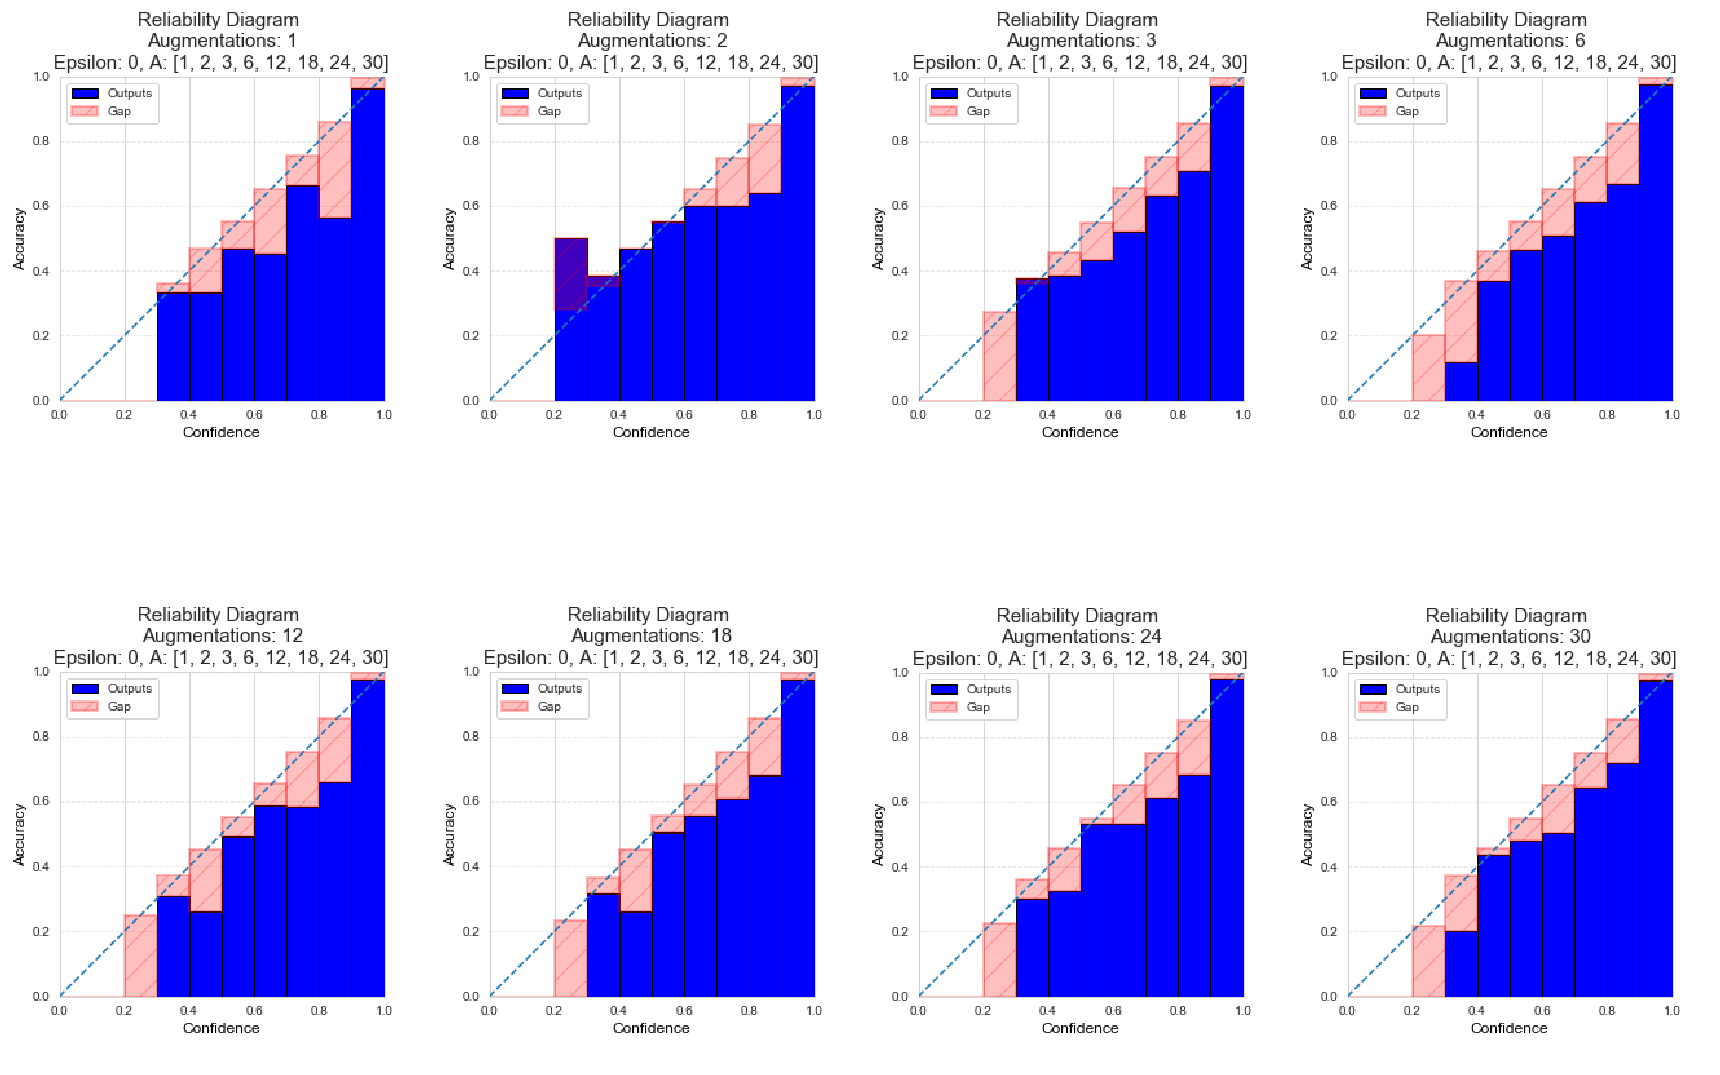

In [27]:
figures=[]
aug = "flr,bra"
n=[1,2,3,6,12,18,24,30]

for count,i in enumerate(n):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=0,
                                                                             augmentations = aug, n = i);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, 0, i)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"_n")
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"_n"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()


Looking at epsilon with augmentations and n:

Epsilon: 0	Test Accuracy = 7039 / 7500 = 0.9385333333333333
Expected Calibration Error: 0.03257258981466293
Epsilon: 0.01	Test Accuracy = 6481 / 7500 = 0.8641333333333333
Expected Calibration Error: 0.0893886461853981
Epsilon: 0.05	Test Accuracy = 4762 / 7500 = 0.6349333333333333
Expected Calibration Error: 0.2922367453575134
Epsilon: 0.1	Test Accuracy = 3751 / 7500 = 0.5001333333333333
Expected Calibration Error: 0.4149194061756134
Epsilon: 0.2	Test Accuracy = 2968 / 7500 = 0.3957333333333333
Expected Calibration Error: 0.4925917088985443
Epsilon: 0.5	Test Accuracy = 1348 / 7500 = 0.17973333333333333
Expected Calibration Error: 0.636915385723114
Epsilon: 1	Test Accuracy = 802 / 7500 = 0.10693333333333334
Expected Calibration Error: 0.6155834197998047
Epsilon: 3	Test Accuracy = 749 / 7500 = 0.09986666666666667
Expected Calibration Error: 0.6124259233474731


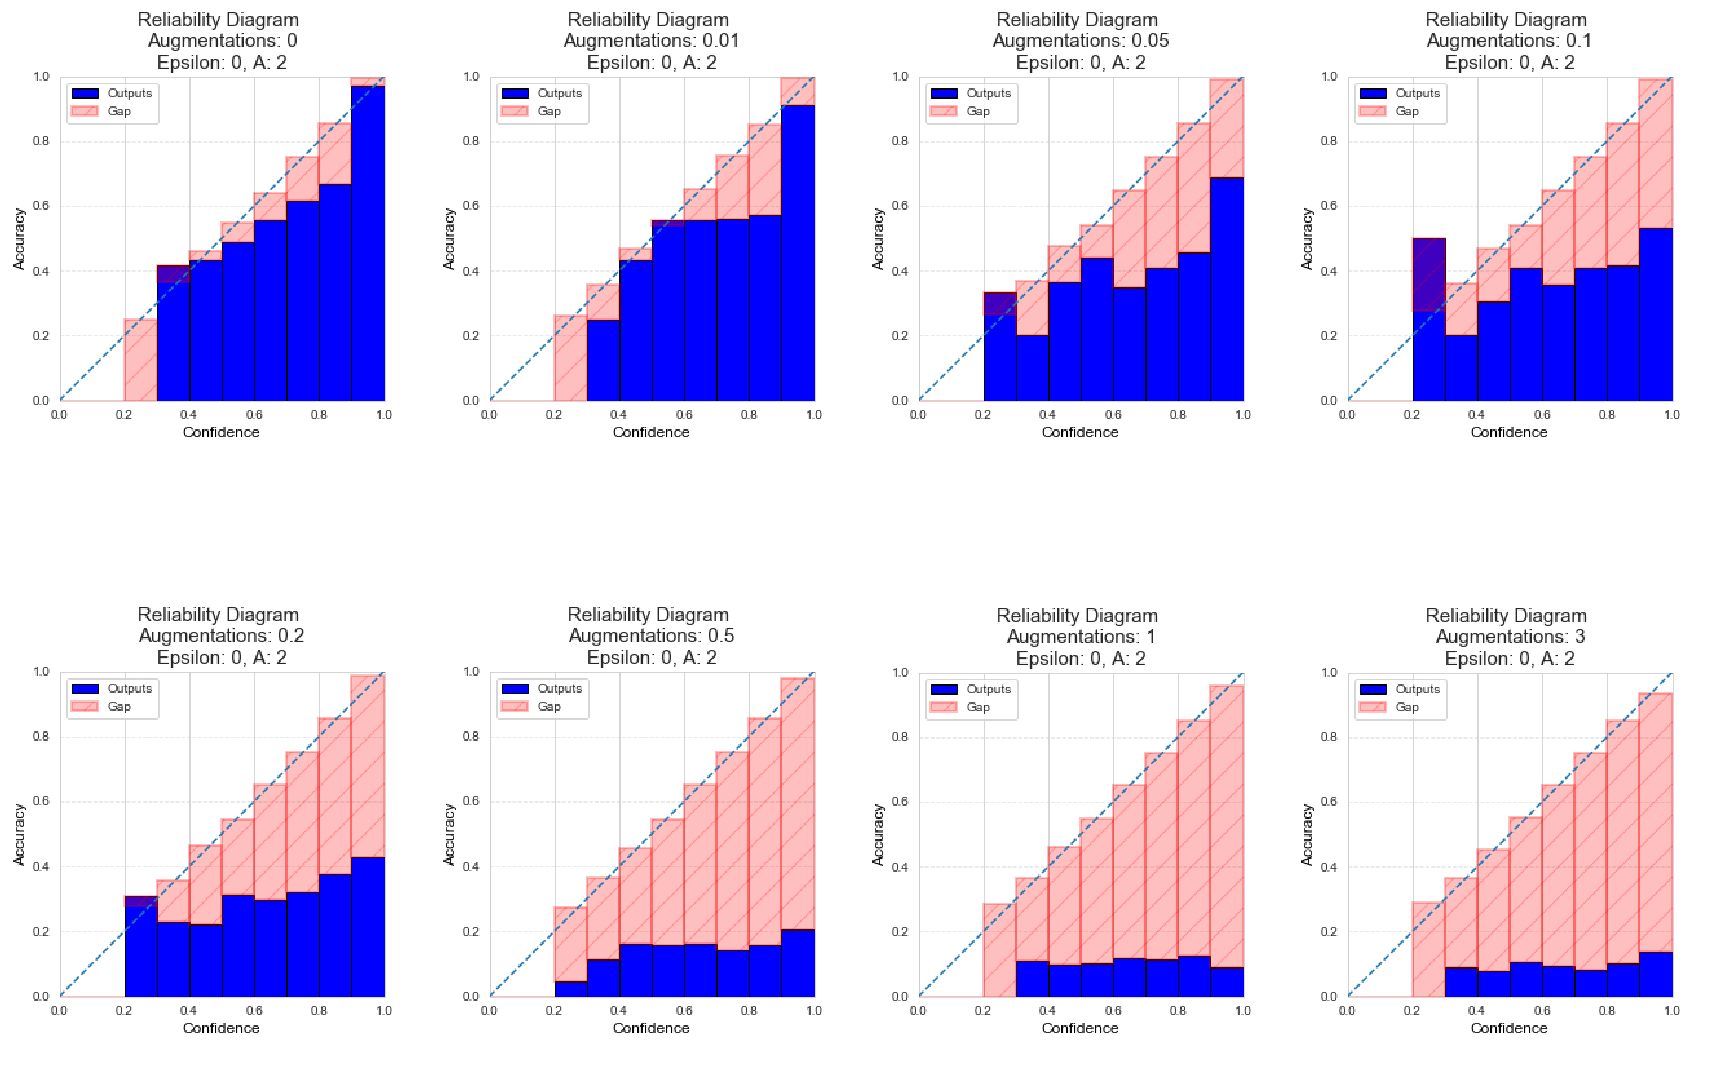

In [29]:
figures=[]
aug = "flr,bra"
n=2
eps=[0, 0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

for count,i in enumerate(eps):
    final_acc, adv_examples, pred_log_probs, target_labels = FGSM.test_augmented(model, validloader, v = 0, 
                                                                             epsilon=i,
                                                                             augmentations = aug, n = n);
    # Get statistics
    pred_acc, pred_conf, pred_labels, _, pred_err_percent=utility.cal_statistics(target_labels, pred_log_probs)
    # Get ECE and bins
    ece, bin_accs, bin_confs, bin_lens=utility.get_bins(target_labels, pred_log_probs)
    title = "Reliability Diagram \nAugmentations: {}\nEpsilon: {}, A: {}".format(aug, i, n)
    figure = utility.reliability_diagram_plot(bin_accs, bin_confs, title=title, plot_n=str(count)+"_eps")
    print("Expected Calibration Error: {}".format(ece))
    figures.append(figure)

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 20 ,20
n_img=len(figures)
row=0
fig, ax = plt.subplots(2,4)
for i in range(n_img):
    # read images
    img = mpimg.imread("figures/"+"reliability_diagram_"+str(i)+"_eps"+".png")
    if i==4:
        row+=1
    if i>=4:
        i-=4
    # display images
    ax[row,i].axis('off')
    ax[row,i].imshow(img);
    plt.tight_layout()

## Detecting errors

In [52]:
def get_good_adversarial(model, dataloader, epsilon, N, n_classes=10, adversarial_attack = FGSM.fgsm_attack_batch):
    samples_class = {}
    for i in range(n_classes):
        samples_class[i] = []
    for data_batch, target_batch in dataloader:
        finished_finding_samples = True
        for i in range(n_classes):
            if len(samples_class[i])<N:
                finished_finding_samples = False
        if finished_finding_samples:
            break
        for original_data, original_target in zip(data_batch, target_batch):
            
            data = original_data.view(1, 3, 32, 32).to(device)
            target = original_target.view(1).to(device)
            
            data.requires_grad = True
            output = F.log_softmax(model(data), dim=1)
            init_pred = output.max(1, keepdim=True)[1]
            
            if init_pred[0].item()!=target[0].item():
                continue
            loss = F.nll_loss(output, target)
            model.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            # create adversarial
            perturbed_data = adversarial_attack(data, epsilon, data_grad)
            
            # run new classification using adversarial attack
            output_adv = F.log_softmax(model(perturbed_data), dim=1)
            final_pred = output_adv.max(1, keepdim=True)[1]
            
            if final_pred[0].item() != target[0].item():
                if len(samples_class[original_target.item()])<N:
                    # each element is ((input data, original class), (adversarial data, predicted class))
                    samples_class[original_target.item()].append(((original_data, original_target), (perturbed_data.squeeze().detach().cpu(), final_pred.squeeze().detach().cpu())))
    
    return samples_class

In [53]:
def get_samples_from_classes(model, dataloader, N, n_classes=10, missclass = False):
    samples_class = {}
    for i in range(n_classes):
        samples_class[i] = []
    for data_batch, target_batch in dataloader:
        finished_finding_samples = True
        for i in range(n_classes):
            if len(samples_class[i])<N:
                finished_finding_samples = False
        if finished_finding_samples:
            break
        for original_data, original_target in zip(data_batch, target_batch):
            
            data = original_data.view(1, 3, 32, 32).to(device)
            target = original_target.view(1).to(device)
            
            output = F.log_softmax(model(data), dim=1)
            pred = output.max(1, keepdim=True)[1]
            
            if missclass:
                criterion = pred[0].item() != target[0].item()
            else:
                criterion = pred[0].item() == target[0].item()
            
            if criterion:
                if len(samples_class[original_target.item()])<N:
                    # each element is: (input data, (original class, predicted class))
                    samples_class[original_target.item()].append((original_data, (original_target, pred.squeeze().detach().cpu())))
    
    return samples_class

Collect samples rom each class, to get unbiased results.

In [67]:
good_adversarials = get_good_adversarial(model, testloader, epsilon= 5, N = 100)

In [59]:
samples_correct = get_samples_from_classes(model, testloader, 100)

In [38]:
samples_missclass = get_samples_from_classes(model, testloader, 100, missclass = True)

To compute the $D_{KL}$ we use the Pytorch analytical KL divergence between categorical variables.

In [39]:
import torch.distributions as td
def get_kl_augmentations(datalist, augmentations, n):
    dkl = []
    for data in datalist:
        data = data.view(1,3,32,32).to(device)
        # only one augmentation at a time
        assert len(augmentations.split(",")) >= 1
        augmented_batch, _, _ = augment.compute_augmentations(data.detach().cpu(),
                                                                n=n, depth=1, augmentations=augmentations, flip_p=1, rot=(-15,-14.9))
        
        for i in range(n):
            data = torch.cat((data, augmented_batch[i].to(device)), 0)
        # concatenate the true image and the augmented image
        output = F.log_softmax(model(data), dim=1)
        
        init_pred = output[0].exp()
        aug_pred = torch.mean(output[1:].exp(),dim=0)
        
        p = td.Categorical(probs=init_pred.detach().cpu())
        q = td.Categorical(probs=aug_pred.detach().cpu())
        dkl.append(td.kl_divergence(p, q).item())
        
    return dkl
        

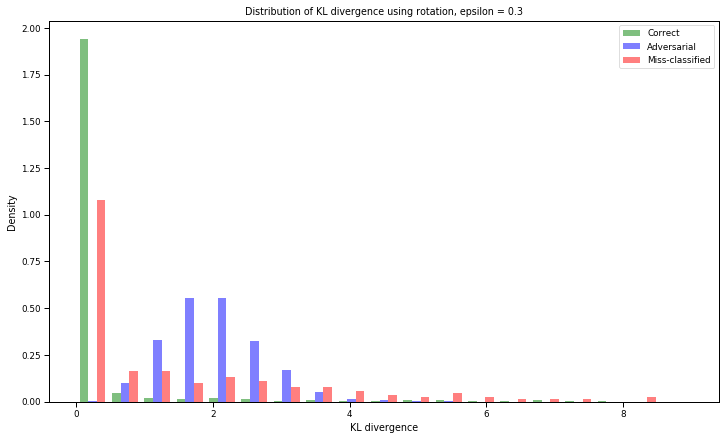

In [68]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = get_kl_augmentations(samples_correct_list, "r", 1)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_kl_augmentations(samples_miss_list, "r", 1)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_kl_augmentations(samples_adv_list, "r", 1)
import seaborn as sns
fig,ax = plt.subplots(figsize = (12,7))
ax.set_title("Distribution of KL divergence using rotation, epsilon = {}".format(0.3))
sns.set_context("paper")
plt.hist([kl_div_correct_r_1,kl_div_adv_r_1, kl_div_missclass_r_1,],bins = list(np.linspace(0,9,20)), color=['g','b','r'],density=True, alpha=0.5, label = ["Correct", "Adversarial", "Miss-classified"])
ax.set_xlabel("KL divergence")
ax.set_ylabel("Density")
ax.legend()

In [42]:
import inspect

def hist_errorbars(data, xerrs=True, label = "", color="r", *args, **kwargs) :
    """Plot a histogram with error bars. Accepts any kwarg accepted by either numpy.histogram or pyplot.errorbar"""
    # pop off normed kwarg, since we want to handle it specially
    norm = False
    if 'normed' in kwargs.keys() :
        norm = kwargs.pop('normed')

    # retrieve the kwargs for numpy.histogram
    histkwargs = {}
    for key, value in kwargs.items() :
        if key in inspect.signature(np.histogram).parameters.keys() :
            histkwargs[key] = value

    histvals, binedges = np.histogram( data, **histkwargs )
    yerrs = np.sqrt(histvals)

    if norm :
        nevents = float(sum(histvals))
        binwidth = (binedges[1]-binedges[0])
        histvals = histvals/nevents/binwidth
        yerrs = yerrs/nevents/binwidth

    bincenters = (binedges[1:]+binedges[:-1])/2

    if xerrs :
        xerrs = (binedges[1]-binedges[0])/2
    else :
        xerrs = None

    # retrieve the kwargs for errorbar
    ebkwargs = {}
    for key, value in kwargs.items() :
        if key in inspect.signature(plt.errorbar).parameters.keys() :
            ebkwargs[key] = value
    out = plt.errorbar(bincenters, histvals, yerrs, xerrs, fmt="s-", capsize = 3,label = label, color=color, **ebkwargs)

    if 'log' in kwargs.keys() :
        if kwargs['log'] :
            plt.yscale('log')

    if 'range' in kwargs.keys() :
        plt.xlim(*kwargs['range'])

    return out

In [43]:
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
kl_div_correct_r_1 = get_kl_augmentations(samples_correct_list, "r", 1)
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]
kl_div_missclass_r_1 = get_kl_augmentations(samples_miss_list, "r", 1)
samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
kl_div_adv_r_1 = get_kl_augmentations(samples_adv_list, "r", 1)

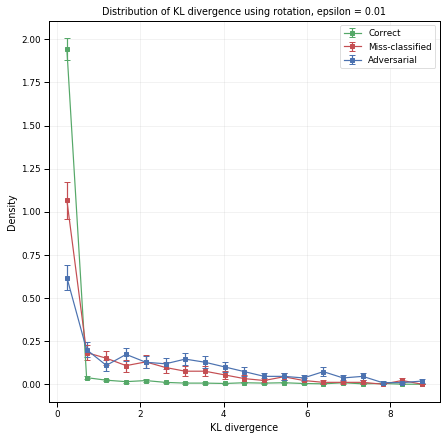

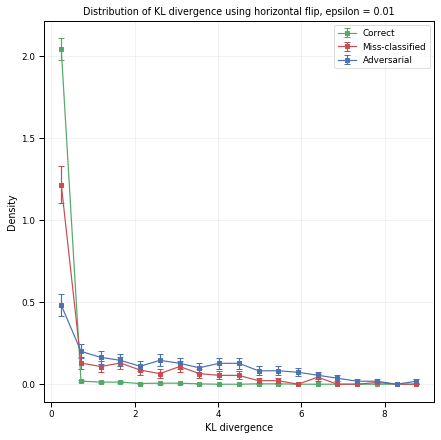

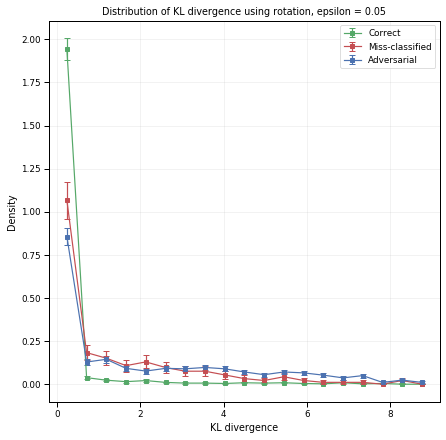

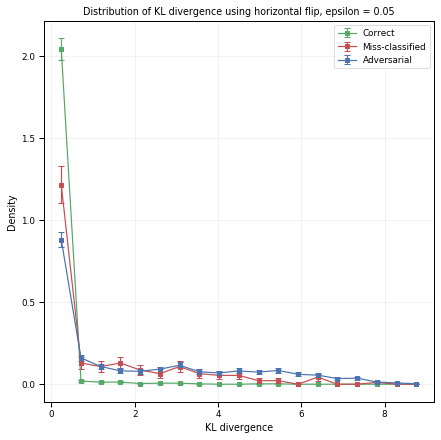

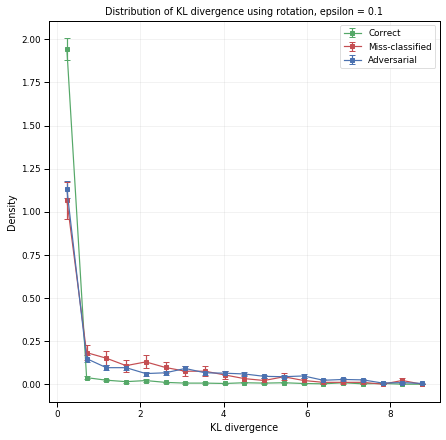

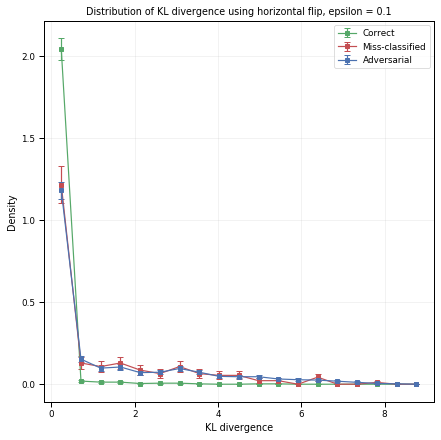

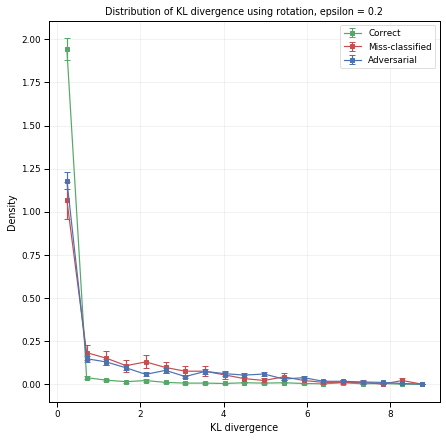

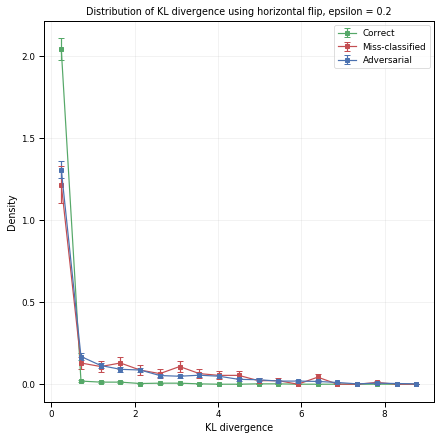

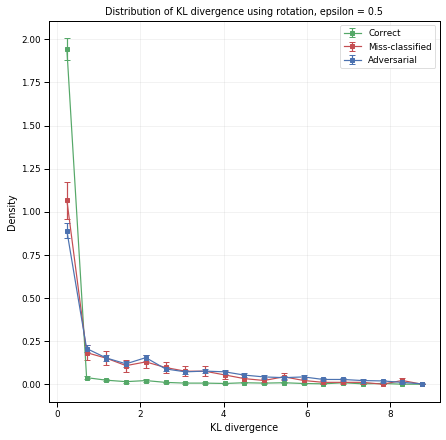

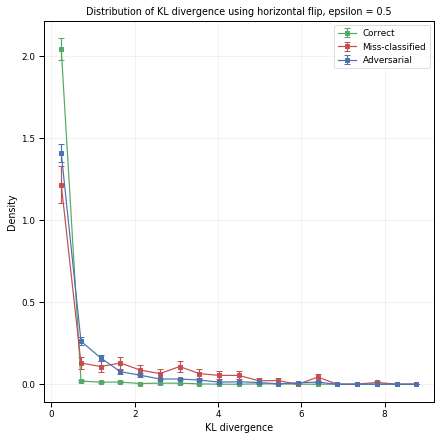

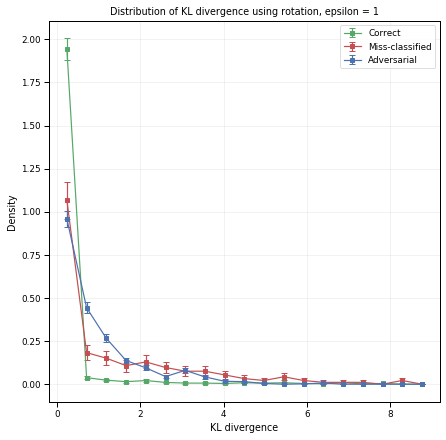

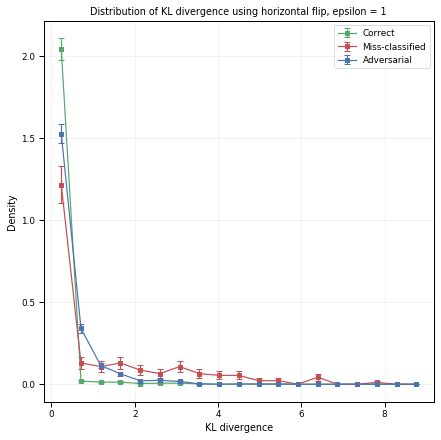

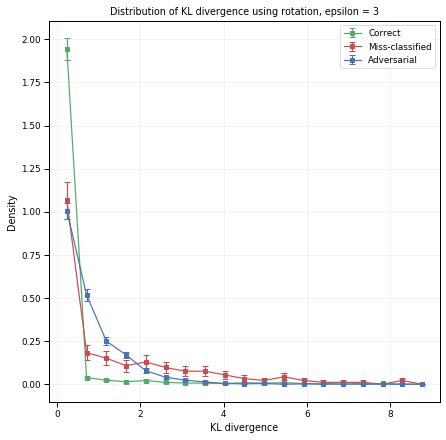

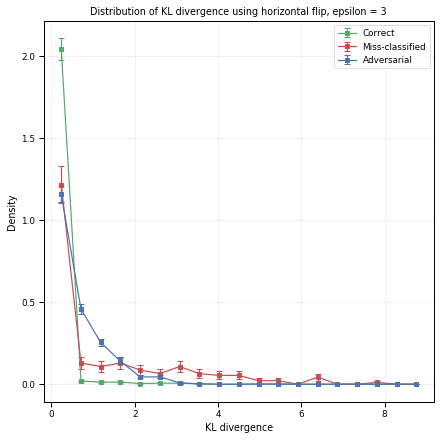

In [55]:
augmentations = [("rotation", "r"), ("horizontal flip", "fliplr")]
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1,3]

cur_aug = "rotation"
cur_eps = 0.3
kl_div_correct = {}
kl_div_missclass = {}
samples_correct_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_correct.values()))]
samples_miss_list = [sample[0] for sample in list(itertools.chain.from_iterable(samples_missclass.values()))]


for cur_augs in augmentations:
    kl_div_missclass[cur_augs[1]] = get_kl_augmentations(samples_miss_list, cur_augs[1], 1)
    kl_div_correct[cur_augs[1]] = get_kl_augmentations(samples_correct_list, cur_augs[1], 1)
    
for cur_eps in epsilons:
    good_adversarials = get_good_adversarial(model, testloader, epsilon= cur_eps, N = 100)
    samples_adv_list = [sample[1][0] for sample in list(itertools.chain.from_iterable(good_adversarials.values()))]
    for cur_augs in augmentations:
        
        kl_div_adv_r_1 = get_kl_augmentations(samples_adv_list, cur_augs[1], 1)
        
        sns.set_context("paper")
        fig,ax = plt.subplots(figsize = (7,7))
        ax.set_title("Distribution of KL divergence using {}, epsilon = {}".format(cur_augs[0], cur_eps))
        hist_errorbars(kl_div_correct[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#55A868", label="Correct")
        hist_errorbars(kl_div_missclass[cur_augs[1]],normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#C44E52", label="Miss-classified")
        hist_errorbars(kl_div_adv_r_1,normed = True,xerrs = False, bins = list(np.linspace(0,9,20)), color="#4C72B0", label="Adversarial")

        ax.grid(alpha = 0.2)
        ax.set_xlabel("KL divergence")
        ax.set_ylabel("Density")
        plt.legend()
        plt.show()
        plt.pause(0.01)